In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-20 04:09:05.392649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 04:09:05.392675: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
df = pd.read_csv('consumos_rh.csv', parse_dates=['date'])
df = df.set_index('date')
df = df.groupby('rh').resample('M').sum()

In [4]:
df

nr
rh date            
+  1999-01-31  5397
   1999-02-28  5325
   1999-03-31  8426
   1999-04-30  6342
   1999-05-31  7776
...             ...
-  2019-08-31  2653
   2019-09-30  2659
   2019-10-31  3206
   2019-11-30  2991
   2019-12-31  2703

[504 rows x 1 columns]

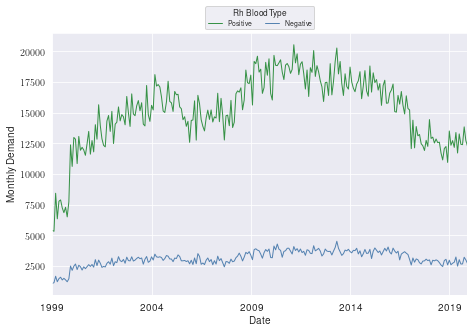

In [5]:
df.pivot_table(values="nr",index="date",columns="rh").plot(figsize=(17*cm,12*cm), linewidth=1, alpha=0.9, color=[colors[2], colors[0]], xlabel='Date', ylabel='Monthly Demand')
plt.legend(['Positive', 'Negative'], title_fontsize='small', fontsize='x-small', title='Rh Blood Type', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)
plt.tight_layout()
plt.savefig('figures/demand_monthly_rh.pdf', bbox_inches = "tight")

### Create batches of training data (12 months)

In [6]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [7]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=100)
    model = Sequential()
    model.add(LSTM(units=100, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mae')
    model.fit(X, y, epochs=500, callbacks=[callback])
    return model 

In [8]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 6, 2, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    #print(X[0], y[0], len(X[0]), len(y[0]))
    model = fit(X, y, n_input, n_output)      
    
    print(actual)
    
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(x_input, current_pred)
    
    return mae, rmse, smape

In [9]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [10]:
def measure_error(actual, pred, step_in, step_out, index):
    print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    mae = mean_absolute_error(actual[index+step_in:index+step_in+step_out], pred)
    rmse = np.sqrt(mean_squared_error(actual[index+step_in:index+step_in+step_out], pred))
    smape = sMAPE(actual[index+step_in:index+step_in+step_out], pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [11]:
df1 = df.pivot_table('nr', 'date', 'rh')
df1['Total'] = df1.sum(axis=1)

In [12]:
dataset = df1[['+', '-']].values
dataset = df1[['+', '-']].astype('float32')
dataset_total = df1[['Total']].values
dataset_total = df1[['Total']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_total = scaler.fit_transform(dataset_total)
mae, rmse, smape = train_predict(dataset[:216], dataset_total[:216], dataset[216:], df1[['Total']][216:].values)

2022-10-07 01:12:09.419986: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-07 01:12:09.420030: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-07 01:12:09.420066: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-07 01:12:09.420538: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
7/7 [==============================] - 3s 24ms/step - loss: 0.6344
Epoch 2/500
7/7 [==============================] - 0s 29ms/step - loss: 0.5228
Epoch 3/500
7/7 [==============================] - 0s 24ms/step - loss: 0.3417
Epoch 4/500
7/7 [==============================] - 0s 17ms/step - loss: 0.1345
Epoch 5/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0777
Epoch 6/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0758
Epoch 7/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0672
Epoch 8/500
7/7 [==============================] - 0s 21ms/step - loss: 0.0667
Epoch 9/500
7/7 [==============================] - 0s 24ms/step - loss: 0.0655
Epoch 10/500
7/7 [==============================] - 0s 24ms/step - loss: 0.0640
Epoch 11/500
7/7 [==============================] - 0s 23ms/step - loss: 0.0635
Epoch 12/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0635
Epoch 13/500
7/7 [==============================]

7/7 [==============================] - 0s 21ms/step - loss: 0.0622
Epoch 205/500
7/7 [==============================] - 0s 22ms/step - loss: 0.0611
Epoch 206/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0618
Epoch 207/500
7/7 [==============================] - 0s 21ms/step - loss: 0.0619
Epoch 208/500
7/7 [==============================] - 0s 22ms/step - loss: 0.0622
Epoch 209/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0627
Epoch 210/500
7/7 [==============================] - 0s 21ms/step - loss: 0.0620
Epoch 211/500
7/7 [==============================] - 0s 25ms/step - loss: 0.0613
Epoch 212/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0615
Epoch 213/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0607
Epoch 214/500
7/7 [==============================] - 0s 24ms/step - loss: 0.0630
Epoch 215/500
7/7 [==============================] - 0s 25ms/step - loss: 0.0605
Epoch 216/500
7/7 [=======================

7/7 [==============================] - 0s 26ms/step - loss: 0.0582
Epoch 407/500
7/7 [==============================] - 0s 26ms/step - loss: 0.0584
Epoch 408/500
7/7 [==============================] - 0s 30ms/step - loss: 0.0584
Epoch 409/500
7/7 [==============================] - 0s 29ms/step - loss: 0.0590
Epoch 410/500
7/7 [==============================] - 0s 26ms/step - loss: 0.0595
Epoch 411/500
7/7 [==============================] - 0s 30ms/step - loss: 0.0591
Epoch 412/500
7/7 [==============================] - 0s 25ms/step - loss: 0.0597
Epoch 413/500
7/7 [==============================] - 0s 24ms/step - loss: 0.0601
Epoch 414/500
7/7 [==============================] - 0s 24ms/step - loss: 0.0600
Epoch 415/500
7/7 [==============================] - 0s 25ms/step - loss: 0.0581
Epoch 416/500
7/7 [==============================] - 0s 25ms/step - loss: 0.0585
Epoch 417/500
7/7 [==============================] - 0s 25ms/step - loss: 0.0583
Epoch 418/500
7/7 [=======================

[[15967]
 [15435]] [[16341.405]
 [16365.478]] 14 16
[[15847]
 [15483]] [[16529.71 ]
 [16522.012]] 16 18
[[15362]
 [14279]] [[16579.523]
 [16509.195]] 18 20
[[13594]
 [15015]] [[16129.137]
 [16068.736]] 20 22
[[15276]
 [13522]] [[15892.536]
 [15828.818]] 22 24
[[16472]
 [14936]] [[15438.162]
 [15439.099]] 24 26
[[15441]
 [14967]] [[15736.337]
 [15771.384]] 26 28
[[16606]
 [14191]] [[15933.164 ]
 [15921.1045]] 28 30
[[16275]
 [15074]] [[16098.729]
 [16037.692]] 30 32
[[15047]
 [17045]] [[16106.98 ]
 [16100.316]] 32 34
[[15719]
 [14969]] [[16503.207]
 [16480.021]] 34 36


### Calculate Error

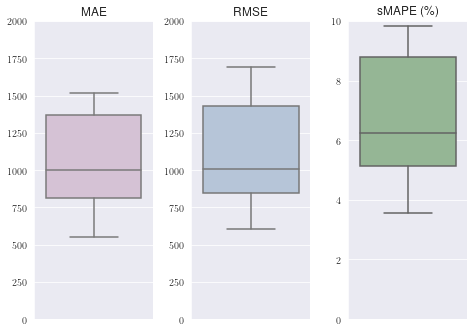

In [25]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 2000))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 2000))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()
plt.savefig('figures/demand_lstm_monthly_rh_boxplot.pdf')

In [26]:
demand_lstm_month_rh = [mae,rmse,smape]
%store demand_lstm_month_rh

Stored 'demand_lstm_month_rh' (list)
